# Détection de Discours Haineux Implicite avec HateBERT

## 1. Imports et Configuration Initiale

In [1]:
import getpass
import os
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import evaluate 

from tqdm.auto import tqdm
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertForSequenceClassification
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from IPython.display import clear_output
from torch.optim import AdamW

## 2. Configuration

In [2]:
MODEL_NAME = 'GroNLP/hateBERT'
DATA_PATH = 'data/implicit-hate-corpus/implicit_hate_v1_stg1_posts.tsv' 
MAX_LENGTH = 512 #max size of the tokenizer https://huggingface.co/GroNLP/hateBERT/commit/f56d507e4b6a64413aff29e541e1b2178ee79d67
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
TEST_SPLIT_SIZE = 0.2 # validation split
RANDOM_SEED = 42
NUM_LABELS = 3 # 0: not hate, 1: implicit hate, 2: explicit hate /// 

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

## 3. Import Data 

In [3]:
#PATH_DATA = "data/implicit-hate-corpus/"
#PATH_INPUT_POSTS = "implicit_hate_v1_SAP_posts.tsv"
#PATH_HATE_LABEL = "implicit_hate_v1_stg1.tsv"
#PATH_CATEGORY_LABEL = "implicit_hate_v1_stg2.tsv"

#input = pd.read_csv(PATH_DATA + PATH_INPUT_POSTS, sep = '\t')
#hate_labels = pd.read_csv(PATH_DATA + PATH_HATE_LABEL, sep = '\t')
#category_labels = pd.read_csv(PATH_DATA + PATH_CATEGORY_LABEL, sep = '\t')



data = pd.read_csv(DATA_PATH, sep = '\t')
print(data)

                                                    post          class
0        " : jewish harvard professor noel ignatiev w...  implicit_hate
1       b.higher education is a part of european cult...       not_hate
2       has a problem with  " the whites " " and " " ...       not_hate
3       is yasir qadhi a hate preacher for calling ch...       not_hate
4       rt  " : how three million germans mass murder...       not_hate
...                                                  ...            ...
21475  Seeing prostitutes is morally wrong, but being...  implicit_hate
21476  I wonder how many females I raped today I spen...  implicit_hate
21477  Having a criminal record is more attractive to...  implicit_hate
21478  Another advantage of being a female: getting b...  implicit_hate
21479  If men are so privileged and women have it so ...  implicit_hate

[21480 rows x 2 columns]


## 4. Data Set  Distribution 

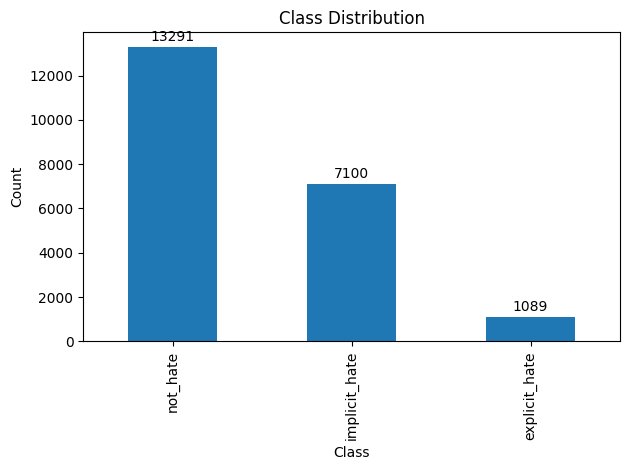

In [4]:

class_counts = data['class'].value_counts()

# Plot
ax = class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

for i, count in enumerate(class_counts):
    plt.text(i, count + max(class_counts)*0.01, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 5. Data preparation (labels and text extraction and remaping)

In [5]:
#Can select only a subset of the data
data = data.head(20)

# Label mappings
id2label = {0: "not_hate", 1: "implicit_hate", 2: "explicit_hate"}
label2id = {"not_hate": 0, "implicit_hate": 1, "explicit_hate": 2}


# Load data text
texts = data['post'].values

# Print raw numeric labels
print("Labels before mapping: \n", data['class'].values[:11])

# Map labels to numeric values
data['class'] = data['class'].map(label2id)
labels = data['class'].values
# Print string labels
print("Labels after mapping:  ", labels[:11])


Labels before mapping: 
 ['implicit_hate' 'not_hate' 'not_hate' 'not_hate' 'not_hate' 'not_hate'
 'implicit_hate' 'not_hate' 'explicit_hate' 'explicit_hate' 'not_hate']
Labels after mapping:   [1 0 0 0 0 0 1 0 2 2 0]


# 6. Load Hate Bert model

We decide to use the Hate Bert model, a Bert model specially trained to detect hate. This model can be use from hugging face [plateforme](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html).

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label, 
    label2id=label2id,
    output_attentions=False,
    output_hidden_states=False
)

print(model.num_parameters())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


109484547


# 7. Load Tokenizer

From hugging face plateforme, we can also load the tokenizer specially made for Hate Bert

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 8. Dataset Initialization

In [8]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return  {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
    
        
           

# 9. Dataset and DataLoader Splitting

In [32]:
# Spliting data (80% train and 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=RANDOM_SEED
)

# TRAIN dataset
train_dataset = HateSpeechDataset(
    texts=train_texts,
    labels=train_labels,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# TESTING dataset
test_dataset = HateSpeechDataset(
    texts=test_texts,
    labels=test_labels,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)


# DATALOADER for training set
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# DATALOADER for testing set
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 10. Training Configuration

We use the default training configuration from the kaggle page

In [10]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Class distribution from your dataset
class_counts = [13291, 7100, 1089]
total = sum(class_counts)

# Inverse frequency (optional: normalize)
class_weights = [total / c for c in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted BCEWithLogitsLoss
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# 11. Scheduler 

In [11]:
num_training_steps = EPOCHS * len(train_dataloader)
# feel free to experiment with different num_warmup_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=1, num_training_steps=num_training_steps
)

# 12. Training 

In [12]:
def train_epoch(model, optimizer, criterion, metrics, train_dataloader, device, epoch, progress_bar):
    # Put the model in train mode
    model.train()

    # Initialize epoch loss
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    # Use tqdm for iterating over the dataloader to see epoch progress
    train_iterator = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{EPOCHS} Training', leave=False)

    # Iterate over batches in training set
    for batch in train_iterator:
        batch = {k: v.to(device) for k, v in batch.items()}

        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        target = batch["labels"]  # Get the target labels

        # Forward pass, get the outputs from the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target)
        logits = outputs.logits

        # Compute the loss
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()

        # Perform one step of the optimizer
        optimizer.step()

        # Learning rate scheduler step
        if 'lr_scheduler' in globals():
            lr_scheduler.step()

        # Zero the gradients
        optimizer.zero_grad()

        # Update progress bar
        progress_bar.update(1)

        # Use argmax to get the predicted class
        preds = torch.argmax(logits, dim=1)

        # Update each metric with the current batch
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds.cpu(), target.cpu())

        # Update loss
        epoch_loss += loss.item()
        
    # for the epoch loss, we compute the average of the metrics over the mini-batches
    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_dataloader)
    
    # Average the loss over all batches
    epoch_loss /= len(train_dataloader)

    # Clear the output and print epoch statistics
    clear_output()  # Clean the prints from previous epochs
    print('Train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, v) for k, v in epoch_metrics.items()]))

    return epoch_loss, epoch_metrics

# 13. Testing

In [13]:
def testing(model, criterion, metrics, test_dataloader, device, epoch, progress_bar):
    # Put the model in eval mode
    model.eval()
    
    # Initialize lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    # Use tqdm for the evaluation dataloader
    eval_iterator = tqdm(test_dataloader, desc='Evaluating Test Set')

    # Iterate over batches of evaluation dataset
    for batch in eval_iterator:
        batch = {k: v.to(device) for k, v in batch.items()}

        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        target = batch["labels"]  # Get the target labels

        with torch.no_grad():
            # Forward pass, get the outputs from the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target)

            # Get the logits from the outputs
            logits = outputs.logits

        # Compute the loss
        loss = criterion(logits, target)
    
        # Use argmax to get the predicted class
        preds = torch.argmax(logits, dim=-1)
        
        # Append predictions and true labels to the lists
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        # Update each metric with the current batch
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds.cpu(), target.cpu())
                
        # Update loss
        epoch_loss += loss.item()
    
        progress_bar.update(1)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_dataloader)
        
    # Average the loss over all batches
    epoch_loss /= len(test_dataloader)

    # Print evaluation results
    print('Eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, v) for k, v in epoch_metrics.items()]))

    return epoch_loss, epoch_metrics

# 14. Plotting the training and testing

In [24]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs, savePicture = True):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    fig.suptitle("Training result of HateBert")
    fig.savefig('figures/training_plot.png')
    plt.show()

def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    '''
    - metrics_names: the keys/names of the logged metrics
    - metrics_log: existing metrics log that will be updated
    - new_metrics_dict: epoch_metrics output from train_epoch and evaluate functions
    '''
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log

# 15. Iterative training and testing

In [15]:
def training_model(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]

    num_training_steps = n_epochs * len(train_dataloader)

    progress_bar = tqdm(range(num_training_steps), desc="Training Progress")

    print(f"Starting training for {EPOCHS} epochs...") # Use EPOCHS from config

    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device,epoch, progress_bar)

        test_loss, test_metrics = testing(model, criterion, metrics, test_loader, device,epoch, progress_bar)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

    progress_bar.close()
    print("Training completed.")
    return train_metrics_log, test_metrics_log


# 16 Evaluation metrics

In [16]:
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

# 17. Main

Train Loss: 1.0094,  ACC: 0.2500, F1-weighted: 0.2063


Evaluating Test Set:   0%|          | 0/1 [00:00<?, ?it/s]

Eval Loss: 1.1126,  ACC: 0.2500, F1-weighted: 0.1667


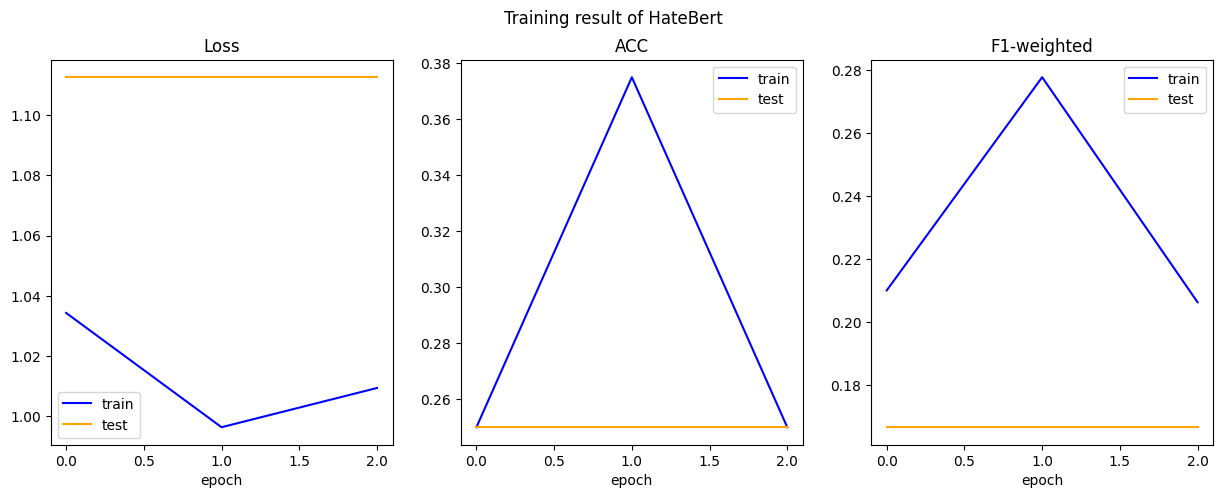

Training completed.


In [28]:
metrics = {'ACC': acc, 'F1-weighted': f1}

model.to(device)
criterion.to(device)

train_metrics_log, test_metrics_log = training_model(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')

# Classification example

In [117]:
n = -1
example_text = texts[n]
example_label = labels[n]
print(f"Example classification: {id2label[example_label]}")

Example sentence: : cnn wants black people to think the president is racist . look around you  your
Example classification: not_hate


In [129]:
def classification(example_text, example_label): 
    #Using the HateBertDataLoader is a bit overkilled, we can just tokenize the input
    encoded_input = tokenizer(
        example_text,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)
    
    model.eval()
    
    with torch.no_grad():
        # Forward pass, get the outputs from the model
        outputs = model(**encoded_input)
        
        # Get the logits from the outputs
        logits = outputs.logits
    
    # Use argmax to get the predicted class
    preds = torch.argmax(logits, dim=-1)
    
    print(f"Example sentence: {example_text}")
    print(f" ---- Model classification: {id2label[int(preds)]}") 
    print(f" ---- Real classification: {id2label[example_label]} \n")

In [130]:
for n in range(0,-5,-1):
    example_text = texts[n]
    example_label = labels[n]
    classification(example_text, example_label)

Example sentence:   " : jewish harvard professor noel ignatiev wants to abolish the white race via #wr " " "
 ---- Model classification: explicit_hate
 ---- Real classification: implicit_hate 

Example sentence: : cnn wants black people to think the president is racist . look around you  your
 ---- Model classification: explicit_hate
 ---- Real classification: not_hate 

Example sentence: : : hate posters ? you want hate buddy ? read the koran . goo ...
 ---- Model classification: implicit_hate
 ---- Real classification: implicit_hate 

Example sentence: 3 ) a white supremacist drove his car into a crowd of people
 ---- Model classification: explicit_hate
 ---- Real classification: not_hate 

Example sentence: . pretty sure trump doesn't want incompetents on his team ...
 ---- Model classification: explicit_hate
 ---- Real classification: not_hate 

